# Introduction

this notebook attempts to answer various data science question from 4 categories 

based on the COVID-19 daily cases, deaths, and recoveries, the focus is primarily on Malaysia.

## The Questions
- Descriptive
    - when did the second wave start?
- Diagnostic
    - what is the percentage of cases that led to death (death rate)?
- Predictive
    - how many cases will Malaysia have by the end of 2020?
- Prescriptive
    - how can we make the number of cases go down before the end of 2020?
    

### other details

- the dataset is obtained from the center for system science and engineering (CSSE) https://github.com/CSSEGISandData/COVID-19

- for predictive analysis, a LSTM model is used to predict the upcoming cases 

    based on solely the previous day’s data considering no other factors, 

    still, LSTM are very popular for such task because of their accuracy and ability to generalize data.

- the used framework for the predictive model is TensorFlow 2.x

- this notebook takes some code from a larger project i have been working on for a while, it’s a modular architecture that can predict cases for any country just given a timeseries of its previous cases using 3 different models, the project can be found here https://www.kaggle.com/abubakaryagob/covid-19-forecasting-automated-edition

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation, GlobalMaxPooling1D
from keras.optimizers import Adam

%matplotlib inline

read in the datasets

In [34]:
df_confirmed = pd.read_csv("../input/covid-19/time_series_covid19_confirmed_global.csv")
df_deaths = pd.read_csv("../input/covid-19/time_series_covid19_deaths_global.csv")
df_reco = pd.read_csv("../input/covid-19/time_series_covid19_recovered_global.csv")

after reading in our dataset lets take a look at it by showing the first few countries for confirmed case, deaths, and recoveries

In [35]:
df_confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,12/2/20,12/3/20,12/4/20,12/5/20,12/6/20,12/7/20,12/8/20,12/9/20,12/10/20,12/11/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,46718,46837,46837,47072,47306,47516,47716,47851,48053,48116
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,39719,40501,41302,42148,42988,43683,44436,45188,46061,46863
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,85084,85927,86730,87502,88252,88825,89416,90014,90579,91121
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,6842,6904,6955,7005,7050,7084,7127,7162,7190,7236
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,15319,15361,15493,15536,15591,15648,15729,15804,15925,16061


each of the dataframes contains data for all countries, 
we only need malaysia so lets extract that from it

In [38]:
my_confirmed = df_confirmed[df_confirmed["Country/Region"] == "Malaysia"]
my_deaths = df_deaths[df_deaths["Country/Region"] == "Malaysia"]
my_reco = df_reco[df_reco["Country/Region"] == "Malaysia"]

now lets take a look at our data for Malaysia

In [39]:
my_confirmed

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,12/2/20,12/3/20,12/4/20,12/5/20,12/6/20,12/7/20,12/8/20,12/9/20,12/10/20,12/11/20
173,NaN,Malaysia,4.210484,101.975766,0,0,0,3,4,4,...,68020,69095,70236,71359,72694,74294,75306,76265,78499,80309


our data is in a format that will not allow us to use it for graphing or predictions,
first we should reshape the data to a format that is more friendly to our goal

In [40]:
# convert passed dataframe to a timeseries (a format easy to graph and use for training models)
def confirmed_timeseries(df):
    df_series = pd.DataFrame(df[df.columns[4:]].sum(),columns=["confirmed"])
    df_series.index = pd.to_datetime(df_series.index,format = '%m/%d/%y')
    return df_series

def deaths_timeseries(df):
    df_series = pd.DataFrame(df[df.columns[4:]].sum(),columns=["deaths"])
    df_series.index = pd.to_datetime(df_series.index,format = '%m/%d/%y')
    return df_series

def reco_timeseries(df):
    # no index to timeseries conversion needed (all is joined later)
    df_series = pd.DataFrame(df[df.columns[4:]].sum(),columns=["recovered"])
    return df_series

In [41]:
# convert each dataframe to a timeseries
my_con_series = confirmed_timeseries(my_confirmed)
my_dea_series = deaths_timeseries(my_deaths)
my_reco_series = reco_timeseries(my_reco)

In [42]:
my_con_series

,confirmed
2020-01-22,0
2020-01-23,0
2020-01-24,0
2020-01-25,3
2020-01-26,4
...,...
2020-12-07,74294
2020-12-08,75306
2020-12-09,76265
2020-12-10,78499


now that we have our data as a time series, lets join all the differnet cases (confirmed, deaths, recovred)
together so its easier to graph them

In [43]:
# join all 3 data frames
my_df = my_con_series.join(my_dea_series, how = "inner")
my_df = my_df.join(my_reco_series, how = "inner")


now lets take a look at our final dataframe

In [44]:
my_df

,confirmed,deaths,recovered
2020-01-22,0,0,0
2020-01-23,0,0,0
2020-01-24,0,0,0
2020-01-25,3,0,0
2020-01-26,4,0,0
...,...,...,...
2020-12-07,74294,384,62306
2020-12-08,75306,388,64056
2020-12-09,76265,393,65124
2020-12-10,78499,396,66236


we can see that its now in a format that is easy to interpret, graph and use for predictions with all columns included

# Descriptive and Diagnostic Analysis

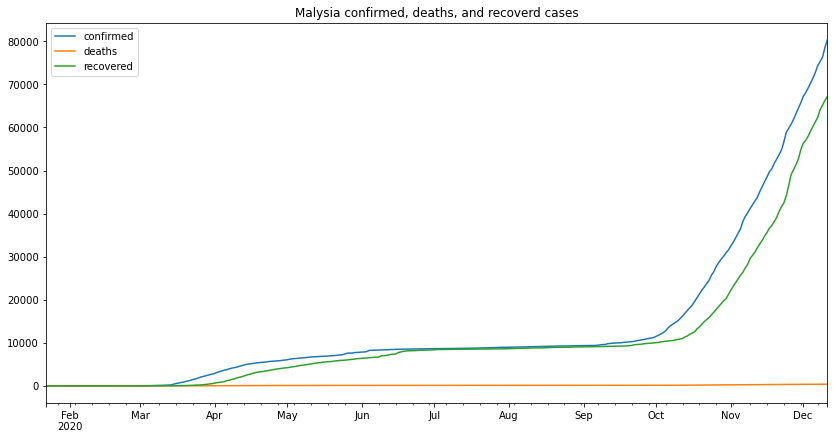

In [45]:
my_df.plot(figsize=(14,7),title="Malysia confirmed, deaths, and recoverd cases")

### Question 1: when did the second wave start?
from the above graph we can make several remarks, one of which
is that the second wave started at the beginning of September and its still going as the time of writing this (13-12-2020)

to calculate the percentage of cases that led to death, 
we first need to know the number of cases that led to an outcome,
from that we can easily extract the number of cases that led to death 
and from that we can calculate the percentage against all the cases that had an outcome

In [46]:
my_cases_outcome = (my_df.tail(1)['deaths'] + my_df.tail(1)['recovered'])[0]
my_outcome_perc = (my_cases_outcome / my_df.tail(1)['confirmed'] * 100)[0]
my_death_perc = (my_df.tail(1)['deaths'] / my_cases_outcome * 100)[0]
my_reco_perc = (my_df.tail(1)['recovered'] / my_cases_outcome * 100)[0]
my_active = (my_df.tail(1)['confirmed'] - my_cases_outcome)[0]

print(f"Number of cases which had an outcome: {my_cases_outcome}")
print(f"percentage of cases that had an outcome: {round(my_outcome_perc, 2)}%")
print(f"Deaths rate: {round(my_death_perc, 2)}%")
print(f"Recovery rate: {round(my_reco_perc, 2)}%")
print(f"Currently Active cases: {my_active}")

Number of cases which had an outcome: 67575
percentage of cases that had an outcome: 84.14%
Deaths rate: 0.59%
Recovery rate: 99.41%
Currently Active cases: 12734


### Question 2: what is the percentage of cases that led to death (death rate)?
we can see from the above results that the percentage of cases that led to death is 0.59%
which is very miniscule in the grand scheme of things, this tells us that although Malaysia has had a considerable number of cases most of them did not end in deaths, in simpler terms, for every 200 cases only 1 death occured.

# Predective and Prescriptive Analaysis
this is where we train an LSTM RNN to predict upcoming cases, we will make predictions for the next 20 days, 
for testing the accuracy of our model, we will take the last 20 days from the dataset and use them for testing

In [59]:
n_input = 20  # number of steps (days to predict)
n_features = 1 # number of y (model outputs)

# preporcess a dataframe and create required vairables for training the LSTM
# train: the data used to make the training generator
# test: the data used to make the test generator
# scaler: data scaler to normalize the data (easier for the model)
# scaled_train: train dataset scaled down to the largest value in the dataset
# scaled test: train dataset scaled down to the largest value in the dataset
# generator: train data generator, used to train the model by feeding it batches of the train data
# validation_generator: validation data generator, used to validate the model during training 
#                       by feeding it batches of a randomly selected points from the train dataset

def prepare_data(df):
    # drop rows with zeros
    df = df[(df.T != 0).any()]
    
    num_days = len(df) - n_input
    train = df.iloc[:num_days]
    test = df.iloc[num_days:]
    
    # normalize the data according to largest value
    scaler = MinMaxScaler()
    scaler.fit(train) # find max value

    scaled_train = scaler.transform(train) # divide every point by max value
    scaled_test = scaler.transform(test)
    
    # feed in batches [t1,t2,t3] --> t4 
    generator = TimeseriesGenerator(scaled_train,scaled_train,length = n_input,batch_size = 1)
    validation_set = np.append(scaled_train[55],scaled_test) # random tbh
    validation_set = validation_set.reshape(n_input + 1,1)
    validation_gen = TimeseriesGenerator(validation_set,validation_set,length = n_input,batch_size = 1)
    
    return scaler, train, test, scaled_train, scaled_test, generator, validation_gen

In [48]:
# create, train and return LSTM model
def train_lstm_model():
    model = Sequential()
    model.add(LSTM(84, recurrent_dropout = 0, return_sequences = True, input_shape = (n_input,n_features)))
    model.add(LSTM(84, recurrent_dropout = 0.1, use_bias = True, return_sequences = True,))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(84, activation = "relu"))
    model.add(Dense(1))

    # compile model
    model.compile(loss = 'mse', optimizer = Adam(1e-5))
    
    # finally train the model using generators
    model.fit_generator(generator,
                        validation_data = validation_gen,
                        epochs = 300,
                        steps_per_epoch = round(len(train) / n_input),
                        verbose = 0
                       )
    
    return model

In [49]:
# predict, rescale and append needed columns to final data frame
def lstm_predict(model):
    # holding predictions
    test_prediction = []

    # last n points from training set
    first_eval_batch = scaled_train[-n_input:]
    current_batch = first_eval_batch.reshape(1,n_input,n_features)
    
    # predict first x days from testing data 
    for i in range(len(test) + n_input):
        current_pred = model.predict(current_batch)[0]
        test_prediction.append(current_pred)
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
        
    # inverse scaled data
    true_prediction = scaler.inverse_transform(test_prediction)

    MAPE, accuracy, sum_errs, interval, stdev, df_forecast = gen_metrics(true_prediction)

    return MAPE, accuracy, sum_errs, interval, stdev, df_forecast

# plotting model losses
def plot_lstm_losses(model):
    pd.DataFrame(model.history.history).plot(figsize = (14,7), title = "loss vs epochs curve")

In [51]:
# generate metrics and final df
def gen_metrics(pred):
    # create time series
    time_series_array = test.index
    for k in range(0, n_input):
        time_series_array = time_series_array.append(time_series_array[-1:] + pd.DateOffset(1))

    # create time series data frame
    df_forecast = pd.DataFrame(columns = ["confirmed","confirmed_predicted"],index = time_series_array)
    
    # append confirmed and predicted confirmed
    df_forecast.loc[:,"confirmed_predicted"] = pred
    df_forecast.loc[:,"confirmed"] = test["confirmed"]
    
    # create and append daily cases (for both actual and predicted)
    daily_act = []
    daily_pred = []
    
    #actual
    daily_act.append(abs(df_forecast["confirmed"].iloc[1] - train["confirmed"].iloc[-1]))
    for num in range((n_input * 2) - 1):
        daily_act.append(df_forecast["confirmed"].iloc[num + 1] - df_forecast["confirmed"].iloc[num])
    
    # predicted
    daily_pred.append(df_forecast["confirmed_predicted"].iloc[1] - train["confirmed"].iloc[-1])
    for num in range((n_input * 2) - 1):
        daily_pred.append(df_forecast["confirmed_predicted"].iloc[num + 1] - df_forecast["confirmed_predicted"].iloc[num])
    
    
    # calculate mean absolute percentage error
    MAPE = np.mean(np.abs(np.array(df_forecast["confirmed"][:n_input]) - 
                          np.array(df_forecast["confirmed_predicted"][:n_input])) /
                   np.array(df_forecast["confirmed"][:n_input]))

    accuracy = round((1 - MAPE) * 100, 2)

    # the error rate
    sum_errs = np.sum((np.array(df_forecast["confirmed"][:n_input]) - np.array(df_forecast["confirmed_predicted"][:n_input])) ** 2)

    # error standard deviation
    stdev = np.sqrt(1 / (n_input - 2) * sum_errs)
    

    # calculate prediction interval
    interval = 1.96 * stdev
    

    # append the min and max cases to final df
    df_forecast["confirm_min"] = df_forecast["confirmed_predicted"] - interval
    df_forecast["confirm_max"] = df_forecast["confirmed_predicted"] + interval
    
    # appened daily data
    df_forecast["daily"] = daily_act
    df_forecast["daily_predicted"] = daily_pred
    
    daily_err = np.sum((np.array(df_forecast["daily"][:n_input]) - np.array(df_forecast["daily_predicted"][:n_input])) ** 2)
    daily_stdev = np.sqrt(1 / (n_input - 2) * daily_err)
    daily_interval = 1.96 * daily_stdev
    
    df_forecast["daily_min"] = df_forecast["daily_predicted"] - daily_interval
    df_forecast["daily_max"] = df_forecast["daily_predicted"] + daily_interval
    
    # round all df values to 0 decimal points
    df_forecast = df_forecast.round() 
    
    return MAPE, accuracy, sum_errs, interval, stdev, df_forecast

In [52]:
# print metrics for given county
def print_metrics(mape, accuracy, errs, interval, std, model_type):
    m_str = "LSTM" if model_type == 0 else "ARIMA" if model_type == 1 else "HES"
    print(f"{m_str} MAPE: {round(mape * 100, 2)}%")
    print(f"{m_str} accuracy: {accuracy}%")
    print(f"{m_str} sum of errors: {round(errs)}")
    print(f"{m_str} prediction interval: {round(interval)}")
    print(f"{m_str} standard deviation: {std}")

In [94]:
# for plotting the range of predicetions
def plot_results(df, country, algo):
    fig, (ax1, ax2) = plt.subplots(2, figsize = (14,20))
    ax1.set_title(f"{country} {algo} confirmed predictions")
    ax1.plot(df.index,df["confirmed"], label = "confirmed")
    ax1.plot(df.index,df["confirmed_predicted"], label = "confirmed_predicted")
    ax1.fill_between(df.index,df["confirm_min"], df["confirm_max"], color = "indigo",alpha = 0.09,label = "Confidence Interval")
    ax1.legend(loc = 2)
    
    ax2.set_title(f"{country} {algo} confirmed daily predictions")
    ax2.plot(df.index, df["daily"], label = "daily")
    ax2.plot(df.index, df["daily_predicted"], label = "daily_predicted")
    ax2.legend()
    
    import matplotlib.dates as mdates
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %-d'))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %-d'))
    fig.show()

## Train the model

In [60]:
# prepare the data (using confirmed cases dataset)

scaler, train, test, scaled_train, scaled_test, generator, validation_gen = prepare_data(my_con_series)

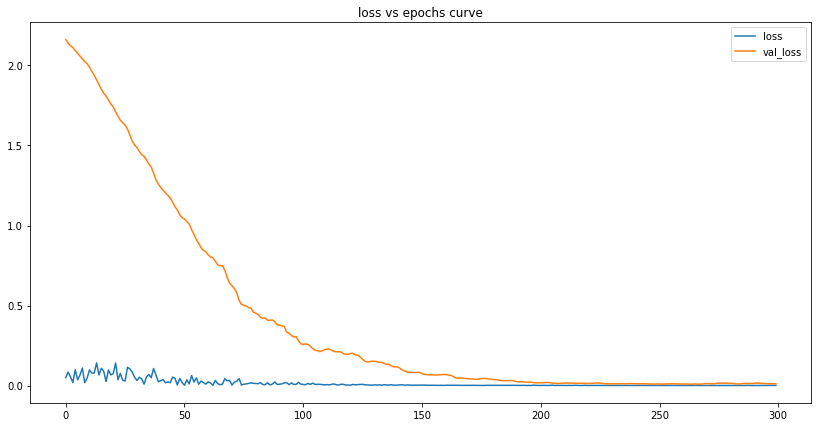

In [61]:
# train lstm model
my_lstm_model = train_lstm_model()

# plot lstm losses
plot_lstm_losses(my_lstm_model)

We can see that the number of losses is tiny at the end of our training. This tells us the model has successfully learned the data and can - to some degree of accuracy - make predictions based on it.

lets first calculate the accuracy for our testing dataset

In [62]:
my_mape, my_accuracy, my_errs, my_interval, my_std, my_lstm_df = lstm_predict(my_lstm_model)

print_metrics(my_mape, my_accuracy, my_errs, my_interval, my_std, 0) # 0 here means LSTM

my_lstm_df

LSTM MAPE: 2.01%
LSTM accuracy: 97.99%
LSTM sum of errors: 43483777.0
LSTM prediction interval: 3046.0
LSTM standard deviation: 1554.2732613061567


,confirmed,confirmed_predicted,confirm_min,confirm_max,daily,daily_predicted,daily_min,daily_max
2020-11-22,54775.0,57453.0,54407.0,60499.0,2980.0,5020.0,3592.0,6448.0
2020-11-23,56659.0,58699.0,55653.0,61746.0,1884.0,1246.0,-182.0,2674.0
2020-11-24,58847.0,59943.0,56896.0,62989.0,2188.0,1243.0,-184.0,2671.0
2020-11-25,59817.0,61181.0,58134.0,64227.0,970.0,1238.0,-190.0,2666.0
2020-11-26,60752.0,62414.0,59368.0,65460.0,935.0,1233.0,-194.0,2661.0
2020-11-27,61861.0,63595.0,60549.0,66641.0,1109.0,1181.0,-247.0,2609.0
2020-11-28,63176.0,64755.0,61708.0,67801.0,1315.0,1160.0,-268.0,2588.0
2020-11-29,64485.0,65907.0,62861.0,68954.0,1309.0,1152.0,-275.0,2580.0
2020-11-30,65697.0,67042.0,63995.0,70088.0,1212.0,1134.0,-293.0,2562.0
2020-12-01,67169.0,68159.0,65113.0,71205.0,1472.0,1117.0,-310.0,2545.0


from the above results we can see that our model predicts the total number of confirmed cases with an accuracy of 97.99%,

On the 11th of December the model predicted 77603 cases which is off compared to the actual number of cases on that day (80k). Based on this, we can conclude that there is always going to be some difference between the prediction and actual data, so we try to extract a range in which the number of cases will fall. Below is the graph for predicted daily cases range.

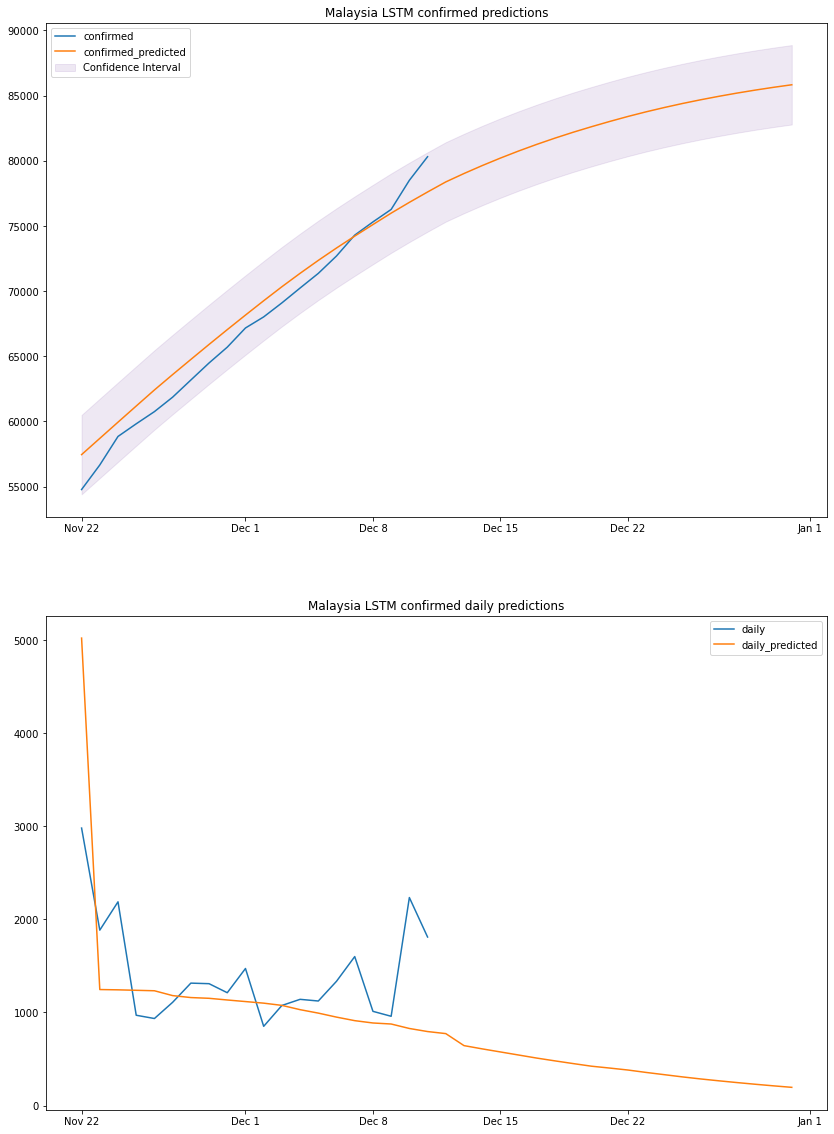

In [95]:
plot_results(my_lstm_df, "Malaysia", "LSTM")

### Question 3: how many cases will Malaysia have by the end of 2020?

based on the above graph and previous dataframe output, we can conclude that by the end of 2020 Malaysia will have a total number of confirmed cases between 82k and 88k.
We should take the predicted daily cases with a grain of salt since the model is linear, it cannot predict non-linear values.

### Question 4: how can we make the number of daily cases go down before the end of 2020?

To answer this question, we have to look back at how did we reduce the number of daily cases and stabilize the number of total confirmed cases in the first wave; the answer is mandated lockdowns.

# Effectiveness of mandated lockdown

Malaysia lockdown started from mid march and some might argue its still ongoing, however the currently ongoing variations of the lockdown are not as strict as the first lockdown and are less effective, here I try to show the effect the first strict lockdown had on the total number of cases, to further support the answer to question 4. 

**restricted lockdown Time frame**  

from 2020-03-16 until 2020-05-04

In [96]:
# generate a dataframe with given range
def get_range_df(start: str, end: str, df):
    target_df = df.loc[pd.to_datetime(start, format='%Y-%m-%d'):pd.to_datetime(end, format='%Y-%m-%d')]
    return target_df

In [88]:
my_lockdown = get_range_df('2020-03-16', '2020-05-04', my_con_series)
my_pre = get_range_df('2020-01-25', '2020-03-16', my_con_series)
my_after = get_range_df('2020-05-04', '2020-12-11', my_con_series)

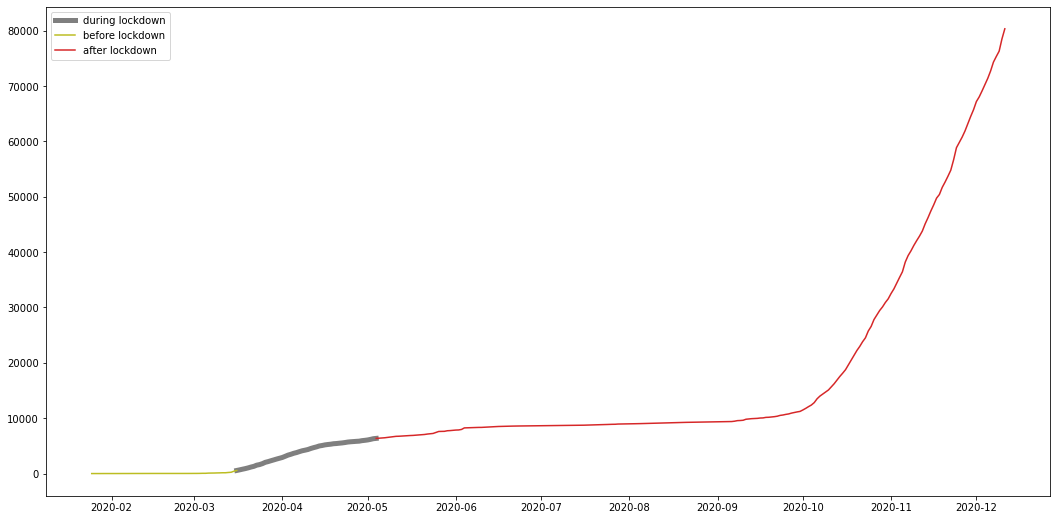

In [93]:


plt.figure(figsize=(18,9))
plt.plot(my_lockdown, color="C7", label="during lockdown", linewidth=5)
plt.plot(my_pre, color="C8", label="before lockdown")
plt.plot(my_after, color="C3", label="after lockdown")
plt.legend()
plt.show()

from the graph we can see that the number of total cases stabilized after the lockdown, meaning the number of daily cases was so low its not even visible on a graph, and this shows the effect the restricted lockdown had on the cases further proving the answer to question 4 to be correct.